## Book Recommendation System

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

# For data manipulation and text analysis
import re
import pandas as pd
import numpy as np

# For data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot settings
plt.rcParams['figure.figsize'] = (7, 4)

In [2]:
# Read data
book_df = pd.read_csv("../data/process_data/books_df.csv", encoding='latin-1')
ratings_df = pd.read_csv("../data/process_data/ratings_df.csv", encoding='latin-1')
user_df = pd.read_csv("../data/process_data/users_df.csv", encoding='latin-1')

In [19]:
# View
ratings_df.head()

,user_id,isbn,book_rating
0,276726,155061224,5
1,276729,521795028,6
2,276736,3257224281,8
3,276737,600570967,6
4,276747,60517794,9


In [20]:
# User dataset view
user_df.head()

,user_id,age,country,city,is_age_missing,isbn,book_rating,age_grp
0,8,30.0,canada,timmins,1,2005018,5,Young Adults
1,8,30.0,canada,timmins,1,887841740,5,Young Adults
2,8,30.0,canada,timmins,1,1552041778,5,Young Adults
3,8,30.0,canada,timmins,1,1567407781,6,Young Adults
4,8,30.0,canada,timmins,1,1575663937,6,Young Adults


In [21]:
# Shape of the data sets
print("Number of Books:", book_df.shape)
print("Number of Ratings:", ratings_df.shape)
print("Number of Users:", user_df.shape)

Number of Books: (122271, 10)
Number of Ratings: (394399, 3)
Number of Users: (375080, 8)


## Data Analysis

In [22]:
# Original number of books: 242135
# After data cleaning, check number of books
print("Total Number of books::", book_df.book_title.nunique())

Total Number of books:: 122271


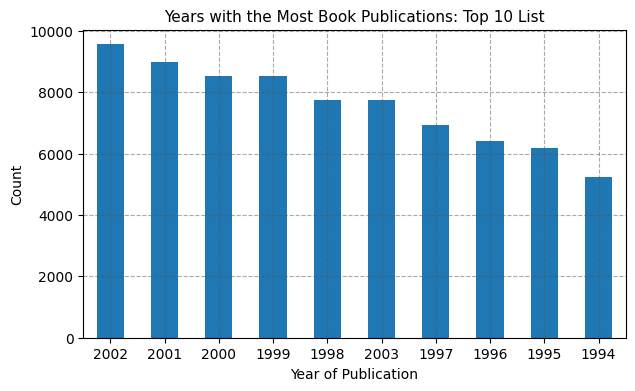

In [23]:
# Examine the number of books published each year.
n_books_per_year = book_df.groupby(by='year_of_publication')['book_title'].count()

# plot
n_books_per_year.sort_values(ascending=False)[:10].plot(kind='bar')
plt.title("Years with the Most Book Publications: Top 10 List", size=11)
plt.xlabel("Year of Publication")
plt.ylabel("Count")

plt.grid(ls='--', color='#555', alpha=0.5)
plt.xticks(rotation=0);

- *Early 2000's and late 90's are the years seems to be the highest number of  published books.*

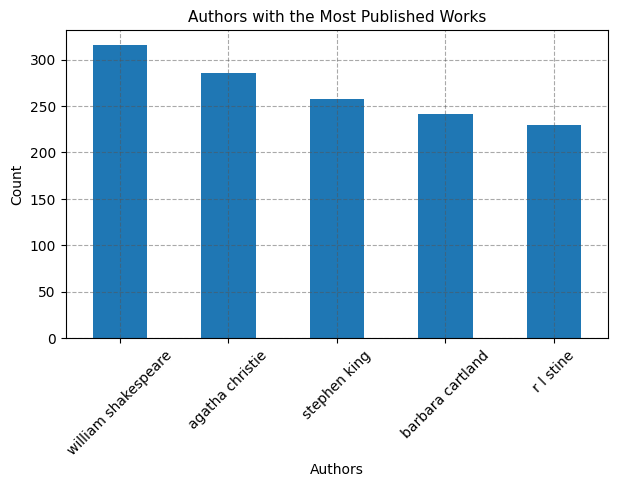

In [24]:
# Find the author with most number of books published.
authors_nbooks = book_df.groupby(by=['book_author'])['book_title'].count().sort_values(ascending=False)[:5]
authors_nbooks.plot(kind='bar')

plt.title("Authors with the Most Published Works", size=11)
plt.xlabel("Authors")
plt.ylabel("Count")

plt.grid(ls='--', color='#555', alpha=0.5)
plt.xticks(rotation=45);

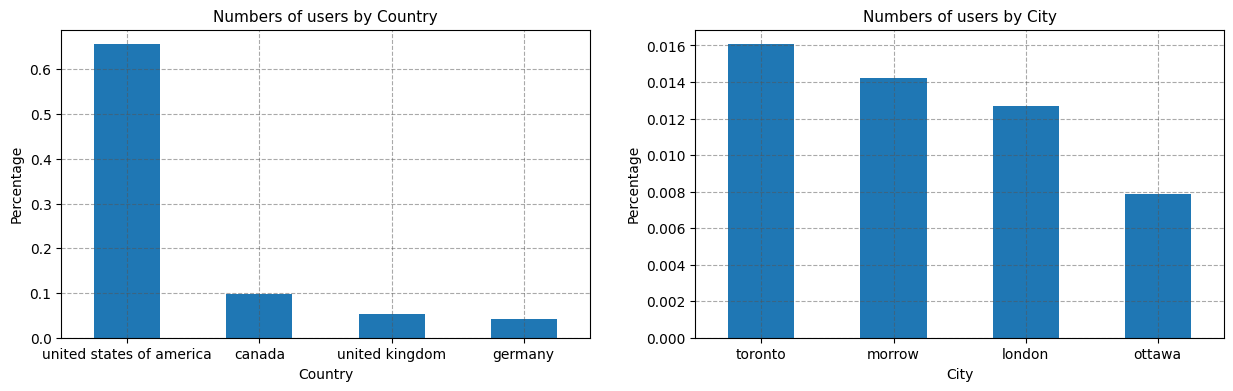

In [25]:
# Examine the number of users by Geography.
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

user_df.country.value_counts(normalize=True)[:4].plot(kind='bar', ax=axs[0])
user_df.city.value_counts(normalize=True)[:4].plot(kind='bar', ax=axs[1])

# Add labels
axs[0].set_xlabel("Country")
axs[1].set_xlabel("City")

axs[0].set_ylabel("Percentage")
axs[1].set_ylabel("Percentage")

axs[0].set_title('Numbers of users by Country', size=11)
axs[1].set_title('Numbers of users by City', size=11)

axs[0].grid(ls='--', c='#555', alpha=0.5)
axs[1].grid(ls='--', c='#555', alpha=0.5)

plt.sca(axs[0])
plt.xticks(rotation=0)

plt.sca(axs[1])
plt.xticks(rotation=0);

- *More than 50% of users are from United States of America.*

## Model Building
### Popularity Based Approach

In [26]:
book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_m,image_url_l,n_votes,total_rating,avg_rating
0,2005018,clara callan,richard bruce wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,9,69,7.666667
1,60973129,decision in normandy,carlo d este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,2,15,7.500000
2,374157065,flu the story of the great influenza pandemic ...,gina bari kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,6,47,7.833333
3,399135782,the kitchen gods wife,amy tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,17,139,8.176471
4,425176428,what if the worlds foremost military historian...,robert cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,1,8,8.000000


- *Let's consider the books with minimum 30 votes to find if it is popular or not.*

In [27]:
# Function to compute the weighted ratings for each book
def calculate_weighted_rating(data, C, M=30):
    '''
    M = Minimum number of votes to be consider popular book.
    C = Average rating across the whole dataset.
    V = Number of votes given by users.
    R = Average rating by users.
    '''
    V = data['n_votes']
    R = data['avg_rating']
    total_n_votes = V + M
    
    weighted_rating = ((V*R) + (M*C)) / total_n_votes
    return weighted_rating

In [28]:
# Calcuate the weighted average ratings for each book.
C = book_df['avg_rating'].mean()
book_df['weighted_rating'] = book_df.apply(calculate_weighted_rating, axis=1, C=C)

In [29]:
# View
book_df.sample(5)

,isbn,book_title,book_author,year_of_publication,publisher,image_url_m,image_url_l,n_votes,total_rating,avg_rating,weighted_rating
4064,192833642,the mill on the floss oxford worlds classics,george eliot,1998,Oxford University Press,http://images.amazon.com/images/P/0192833642.0...,http://images.amazon.com/images/P/0192833642.0...,3,23,7.666667,7.531605
70403,743436113,forge of the titans,steve white,2003,Baen Books,http://images.amazon.com/images/P/0743436113.0...,http://images.amazon.com/images/P/0743436113.0...,1,9,9.000000,7.565902
77834,312940270,the beast that shouted love at the heart of th...,harlan ellison,1984,St Martins Pr,http://images.amazon.com/images/P/0312940270.0...,http://images.amazon.com/images/P/0312940270.0...,2,19,9.500000,7.641967
3,399135782,the kitchen gods wife,amy tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,17,139,8.176471,7.756233
81030,812524810,legacy eon,greg bear,1996,Tor Science Fiction,http://images.amazon.com/images/P/0812524810.0...,http://images.amazon.com/images/P/0812524810.0...,3,23,7.666667,7.531605


In [30]:
# Save this book dataframe with weigthed ratings
book_df.to_csv("../data/final_data/final_book_df.csv", index=False)

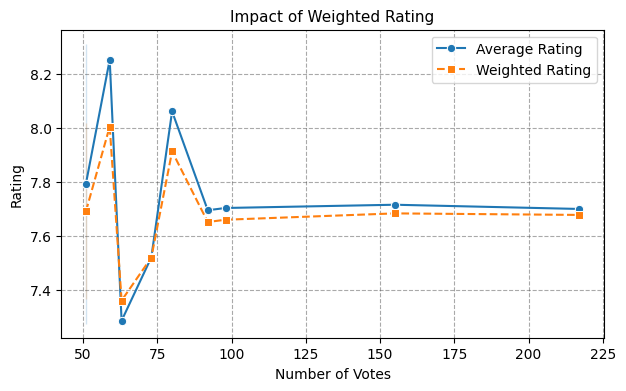

In [31]:
# Impact of weighted rating
book_data = book_df[(book_df['n_votes'] > 50)].sample(10)

sns.lineplot(book_data, x='n_votes', y='avg_rating', ls='-', marker='o', label='Average Rating')
sns.lineplot(book_data, x='n_votes', y='weighted_rating', ls='--', marker='s',  label='Weighted Rating')

plt.xlabel('Number of Votes')
plt.ylabel('Rating')
plt.title('Impact of Weighted Rating', size=11)

plt.grid(ls='--', c='#555', alpha=0.5)
plt.legend()
plt.show()

- *The line plot shows how the weighted rating changes with number of votes compated to the average rating.*

In [32]:
# Top 50 most popular books
top50_popular_books = book_df.sort_values(by=['weighted_rating'], ascending=False)[:50]
top50_popular_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_m,image_url_l,n_votes,total_rating,avg_rating,weighted_rating
4175,439139597,harry potter and the goblet of fire book 4,j k rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,137,1269,9.262774,8.949359
3233,345339738,the return of the king the lord of the rings p...,j r r tolkien,1986,Del Rey,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...,77,724,9.402597,8.874233
2969,439136350,harry potter and the prisoner of azkaban book 3,j k rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,141,1274,9.035461,8.769257
29,446310786,to kill a mockingbird,harper lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,214,1914,8.943925,8.768619
623,345339711,the two towers the lord of the rings part 2,j r r tolkien,1986,Del Rey,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...,83,757,9.120482,8.695070


### Popular books 

In [33]:
# Prepare dataset that contains information about user, books, ratings.
user_book_df = book_df[['isbn', 'book_title', 'book_author', 'n_votes']].merge(user_df, on='isbn')
user_book_df.head()

,isbn,book_title,book_author,n_votes,user_id,age,country,city,is_age_missing,book_rating,age_grp
0,2005018,clara callan,richard bruce wright,9,8,30.0,canada,timmins,1,5,Young Adults
1,2005018,clara callan,richard bruce wright,9,67544,30.0,canada,toronto,0,8,Young Adults
2,2005018,clara callan,richard bruce wright,9,123629,30.0,canada,kingston,1,9,Young Adults
3,2005018,clara callan,richard bruce wright,9,200273,30.0,canada,comber,1,8,Young Adults
4,2005018,clara callan,richard bruce wright,9,210926,30.0,canada,guelph,1,9,Young Adults


In [34]:
# Find the popular books
def get_popular_book(data, col):
    
    avg_rating_by_col = data.groupby(by=[col, 'book_title'])['book_rating'].aggregate(['count', 'mean']).reset_index()
    avg_rating_by_col.rename(columns={'count':'n_votes', 'mean': 'avg_rating'}, inplace=True)
    
    # Calcuate the weighted average ratings for each book.
    C = avg_rating_by_col['avg_rating'].mean()
    avg_rating_by_col['weighted_rating'] = avg_rating_by_col.apply(calculate_weighted_rating, axis=1, C=C)
    
    popular_book_list = avg_rating_by_col.groupby(by=[col])['weighted_rating'].nlargest(1).index.tolist()
    popular_book_idxs = [idx for c, idx in popular_book_list]

    return avg_rating_by_col.iloc[popular_book_idxs][[col, 'book_title', 'weighted_rating']]

In [35]:
# Popular books by 'Country'
get_popular_book(user_book_df, 'country').sort_values(by='weighted_rating', ascending=False)[:5]

,country,book_title,weighted_rating
88748,united states of america,harry potter and the goblet of fire book 4,9.036273
54986,united kingdom,free,8.189057
10796,canada,fast food nation the dark side of the allameri...,8.167367
33027,germany,maus 1 mein vater kotzt geschichte aus die ges...,8.084208
27316,france,le petit prince,8.008770


In [36]:
# Popular books by 'age'
age_user_df = user_book_df.dropna()
get_popular_book(age_user_df, 'age_grp')

,age_grp,book_title,weighted_rating
55641,Adults,to kill a mockingbird,8.520642
61354,Childern,harry potter and the chamber of secrets book 2,7.896068
66829,Seniors,the da vinci code,8.041445
70579,Teens,harry potter and the goblet of fire book 4,8.340883
96804,Young Adults,harry potter and the goblet of fire book 4,8.764793


In [37]:
# Popular books in the actual data where age is not missing.
get_popular_book(age_user_df.query('is_age_missing == 0'), 'age_grp')

,age_grp,book_title,weighted_rating
48787,Adults,to kill a mockingbird,8.564804
53836,Childern,harry potter and the chamber of secrets book 2,7.979345
59249,Seniors,the da vinci code,8.092580
62951,Teens,harry potter and the goblet of fire book 4,8.401606
112575,Young Adults,the return of the king the lord of the rings p...,8.761101


### Collabrative System

We have a large amount of user data with book rating. So, we can use collabrative filtering approach to recommend books based on similar liking between the users.

Let's consider both users and books with certain number of votes to be popular. 

- *Users*: with more than **120** votes
- *Books*: with more than **50** votes.

In [38]:
# Users with minimum 250 votes
user_vote_count = user_book_df.groupby(by=['user_id'])['book_rating'].count()
users_list = user_vote_count[user_vote_count >= 120].index.tolist()

# Filtered data
a = user_book_df[user_book_df.user_id.isin(users_list)].reset_index(drop=True)

In [39]:
# Books with minimum 50 votes
book_vote_count = user_book_df.groupby('isbn')['book_rating'].count()
books_list = book_vote_count[book_vote_count >= 50].index.tolist()

# Filtered data
b = a[a.isbn.isin(books_list)].reset_index(drop=True)

In [41]:
b.to_csv("../data/final_data/filter_data.csv", index=False)

### Recommendation Systems

In [42]:
# Import libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

# Get the list of stopwords in english
stop_words = set(stopwords.words('english'))

#### Approach 1: Simple Search Keyword

Book recommendation by simply searching similar keyword in data.

In [43]:
"""Find similar book based on search text keyword."""
def search_book(search_text, data=b, n_recommendations=10):
    # Tokenize the text
    keywords = word_tokenize(search_text.lower())

    # Filter out the stopwords
    filtered_kw = [word for word in keywords if word not in stop_words]
    
    # Get the unique book title from the filtered data b.
    book_titles = data.book_title.unique().tolist()

    # Search the similar books for the given search text.
    similar_books = []
    for book in book_titles:
        if any(word in book for word in filtered_kw):
            similar_books.append(book)
            
    if similar_books:
        return book_df[book_df.book_title.isin(similar_books)].head(n_recommendations)
    else:
        return "No Book Found!"

In [44]:
search_book('a walk to remember')

,isbn,book_title,book_author,year_of_publication,publisher,image_url_m,image_url_l,n_votes,total_rating,avg_rating,weighted_rating
1112,767902521,a walk in the woods rediscovering america on t...,bill bryson,1999,Broadway Books,http://images.amazon.com/images/P/0767902521.0...,http://images.amazon.com/images/P/0767902521.0...,106,870,8.207547,8.055463
3628,441790348,stranger in a strange land remembering tomorrow,robert a heinlein,1995,ACE Charter,http://images.amazon.com/images/P/0441790348.0...,http://images.amazon.com/images/P/0441790348.0...,72,600,8.333333,8.093558
4300,446608955,a walk to remember,nicholas sparks,2000,Warner Books,http://images.amazon.com/images/P/0446608955.0...,http://images.amazon.com/images/P/0446608955.0...,124,974,7.854839,7.789240
5982,441569595,neuromancer remembering tomorrow,william gibson,1995,Ace Books,http://images.amazon.com/images/P/0441569595.0...,http://images.amazon.com/images/P/0441569595.0...,77,586,7.610390,7.584514
6222,441172717,dune remembering tomorrow,frank herbert,1996,ACE Charter,http://images.amazon.com/images/P/0441172717.0...,http://images.amazon.com/images/P/0441172717.0...,75,673,8.973333,8.557552


#### Approach 2: Pearsons' Correlation

Recommendations using pearson's correlations.

In [45]:
def get_data_by(age):
    if age:
        if age < 13:
            return b[b.age_grp == 'Childern']
        elif 12 < age <= 18:
            return b[b.age_grp == 'Teens']
        elif 18 < age <= 35:
            return b[b.age_grp == 'Young Adults']
        elif 35 < age <= 60:
            return b[b.age_grp == 'Adults']
        elif age > 60:
            return b[b.age_grp == 'Seniors']
    else:
        return b

In [46]:
"""Book Recommendation System using Pearson's correlation."""
def recommendation_system1(search_text, n_recommendations=10, age=None):
    search_text = search_text.lower()
    
    # Filter data by age
    filtered_book_df = get_data_by(age)
            
    # compute correlation.
    corr_pt = pd.pivot_table(filtered_book_df, index='user_id', columns='isbn', values='book_rating').fillna(0)
    correlation_matrix = corr_pt.corr(method='pearson')
    
    try:
        search_book_isbn = book_df[book_df.book_title == search_text]['isbn'].values[0]
        similar_books = correlation_matrix[search_book_isbn].sort_values(ascending=False)[:n_recommendations].index
        similar_books_df = pd.DataFrame({'isbn': similar_books})
        return pd.merge(similar_books_df, book_df, on='isbn', how='left')
    except:
        return search_book(search_text, filtered_book_df, n_recommendations)

In [47]:
search_text = 'a Walk to remeMber'
recommendation_system1(search_text, n_recommendations=10)

,isbn,book_title,book_author,year_of_publication,publisher,image_url_m,image_url_l,n_votes,total_rating,avg_rating,weighted_rating
0,446608955,a walk to remember,nicholas sparks,2000,Warner Books,http://images.amazon.com/images/P/0446608955.0...,http://images.amazon.com/images/P/0446608955.0...,124,974,7.854839,7.789240
1,446605239,the notebook,nicholas sparks,1998,Warner Books,http://images.amazon.com/images/P/0446605239.0...,http://images.amazon.com/images/P/0446605239.0...,206,1584,7.689320,7.667555
2,446531332,nights in rodanthe,nicholas sparks,2002,Warner Books,http://images.amazon.com/images/P/0446531332.0...,http://images.amazon.com/images/P/0446531332.0...,65,506,7.784615,7.700452
3,64407667,the bad beginning a series of unfortunate even...,lemony snicket,1999,HarperCollins,http://images.amazon.com/images/P/0064407667.0...,http://images.amazon.com/images/P/0064407667.0...,113,833,7.371681,7.402398
4,375412824,the dive from clausens pier alex awards,ann packer,2002,Knopf,http://images.amazon.com/images/P/0375412824.0...,http://images.amazon.com/images/P/0375412824.0...,55,409,7.436364,7.465211
5,786867647,lucky man a memoir,michael j fox,2002,Hyperion,http://images.amazon.com/images/P/0786867647.0...,http://images.amazon.com/images/P/0786867647.0...,65,535,8.230769,8.005715
6,446364193,along came a spider alex cross novels,james patterson,1993,Warner Books,http://images.amazon.com/images/P/0446364193.0...,http://images.amazon.com/images/P/0446364193.0...,116,932,8.034483,7.928376
7,345439104,drowning ruth oprahs book club,christina schwarz,2001,Ballantine Books,http://images.amazon.com/images/P/0345439104.0...,http://images.amazon.com/images/P/0345439104.0...,95,713,7.505263,7.508344
8,743211375,from a buick 8 a novel,stephen king,2002,Scribner,http://images.amazon.com/images/P/0743211375.0...,http://images.amazon.com/images/P/0743211375.0...,59,430,7.288136,7.365651
9,385484518,tuesdays with morrie an old man a young man an...,mitch albom,1997,Doubleday,http://images.amazon.com/images/P/0385484518.0...,http://images.amazon.com/images/P/0385484518.0...,200,1723,8.615000,8.471926


### Approach 3: Cosine Similarity

Item-based collaborative filtering using Cosine Similarity.

In [94]:
"""Book recommendation system using Cosine Similarity."""
def recommendation_system2(search_text, n_recommendations=10, age=None):
    search_text = search_text.lower()
    try:
        # Filter data by age
        filtered_book_df = get_data_by(age)
        
        # Create pivot table that displays the users with ratings
        rating_pt = pd.pivot_table(filtered_book_df, index='isbn', columns='user_id', values='book_rating')
        rating_pt = rating_pt.fillna(0)
        
        # Compute the similarity score
        similarity_score = cosine_similarity(rating_pt)
        cosimilarity_matrix = pd.DataFrame(similarity_score, columns=rating_pt.index, index=rating_pt.index)
        
        # Search book title in cosimilarity matrix.
        search_book_isbn = book_df[book_df.book_title == search_text]['isbn'].values[0]
        similar_books = cosimilarity_matrix[search_book_isbn].sort_values(ascending=False)[:n_recommendations].index
        similar_books_df = pd.DataFrame({'isbn': similar_books})
        return pd.merge(similar_books_df, book_df, on='isbn', how='left').T.to_dict()
        
    except:
        return search_book(search_text, filtered_book_df, n_recommendations)

In [95]:
search_text = 'a Walk to remeMber'
recommendation_system2(search_text, n_recommendations=2)

{0: {'isbn': 446608955,
  'book_title': 'a walk to remember',
  'book_author': 'nicholas sparks',
  'year_of_publication': 2000,
  'publisher': 'Warner Books',
  'image_url_m': 'http://images.amazon.com/images/P/0446608955.01.MZZZZZZZ.jpg',
  'image_url_l': 'http://images.amazon.com/images/P/0446608955.01.LZZZZZZZ.jpg',
  'n_votes': 124,
  'total_rating': 974,
  'avg_rating': 7.854838709677419,
  'weighted_rating': 7.789239951992272},
 1: {'isbn': 446605239,
  'book_title': 'the notebook',
  'book_author': 'nicholas sparks',
  'year_of_publication': 1998,
  'publisher': 'Warner Books',
  'image_url_m': 'http://images.amazon.com/images/P/0446605239.01.MZZZZZZZ.jpg',
  'image_url_l': 'http://images.amazon.com/images/P/0446605239.01.LZZZZZZZ.jpg',
  'n_votes': 206,
  'total_rating': 1584,
  'avg_rating': 7.689320388349515,
  'weighted_rating': 7.667554883927161}}

### Model Evaluation

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_score_atK(y_true, y_preds, k):
    """Precision and Recall metrics measures how accurately the system predicts 
    user preferences.
        - Precision@K: The proportion of recommended items in the top-K predicitons.
        - Recall@K: The proportion of relevent items that are recommended in the top-K set.
    """
    precision_at_k = precision_score(y_true[:k], y_preds[:k], average='micro')
    recall_at_k = recall_score(y_true[:k], y_preds[:k], average='micro')
    f1score_at_k = recall_score(y_true[:k], y_preds[:k], average='micro')
    
    return precision_at_k, recall_at_k, f1score_at_k

In [51]:
# Model performance for search text = 'a Walk to remeMber' for top 20 recommendations.
y_true = ['romance']*20
y_predictions = ['romance', 'romance', 'romance', 'fantacy', 'romance', 'biography', 
                 'historical fiction', 'mystery', 'fantacy', 'classics', 'fantacy', 
                 'romance', 'romance', 'fantacy', 'romance', 'romance', 'philosophy', 
                 'drama', 'romance', 'fantacy']

scores = []
for k in [3, 5, 7, 10, 15, 20]:
    precision, recall, f1score = get_score_atK(y_true, y_predictions, k)
    scores.append((k, precision, recall, f1score))

pd.DataFrame(scores, columns=['TopK recommendation', 'Precision', 'Recall', 'F1score'])

,TopK recommendation,Precision,Recall,F1score
0,3,1.000000,1.000000,1.000000
1,5,0.800000,0.800000,0.800000
2,7,0.571429,0.571429,0.571429
3,10,0.400000,0.400000,0.400000
4,15,0.466667,0.466667,0.466667
5,20,0.450000,0.450000,0.450000


In [55]:
search_text = 'harry potter and the sorcerers stone book 1'
recommendation_system2(search_text, n_recommendations=5)

,isbn,book_title,book_author,year_of_publication,publisher,image_url_m,image_url_l,n_votes,total_rating,avg_rating,weighted_rating
0,590353403,harry potter and the sorcerers stone book 1,j k rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,119,1069,8.983193,8.688208
1,439136350,harry potter and the prisoner of azkaban book 3,j k rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,141,1274,9.035461,8.769257
2,439139597,harry potter and the goblet of fire book 4,j k rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,137,1269,9.262774,8.949359
3,743227441,the other boleyn girl,philippa gregory,2002,Touchstone,http://images.amazon.com/images/P/0743227441.0...,http://images.amazon.com/images/P/0743227441.0...,88,742,8.431818,8.199517
4,140067477,the tao of pooh,benjamin hoff,1983,Penguin Books,http://images.amazon.com/images/P/0140067477.0...,http://images.amazon.com/images/P/0140067477.0...,102,820,8.039216,7.920780


In [53]:
# Model performance for search text = 'harry potter and the sorcerers stone book 1' for top 20 recommendations.
y_true = ['fantacy']*20
y_predictions = ['fantacy', 'fantacy', 'fantacy', 'romance', 'philosophy', 'mystery', 'classics', 
                'romance','fantacy', 'Horror','mystery', 'fantacy', 'mystery', 'mystery', 'nonfiction', 
                'mystery','fantacy', 'history', 'romance', 'fantacy']

scores = []
for k in [3, 5, 7, 10, 15, 20]:
    precision, recall, f1score = get_score_atK(y_true, y_predictions, k)
    scores.append((k, precision, recall, f1score))

pd.DataFrame(scores, columns=['TopK recommendation', 'Precision', 'Recall', 'F1score'])

,TopK recommendation,Precision,Recall,F1score
0,3,1.000000,1.000000,1.000000
1,5,0.600000,0.600000,0.600000
2,7,0.428571,0.428571,0.428571
3,10,0.400000,0.400000,0.400000
4,15,0.333333,0.333333,0.333333
5,20,0.350000,0.350000,0.350000
